<a href="https://colab.research.google.com/github/matthewhasman/ML-on-Microcontrollers/blob/main/ML_MCU_NN_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install hub to pull dataset

In [ ]:
!apt install subversion
!svn checkout https://github.com/Jakobovski/free-spoken-digit-dataset/trunk/recordings;

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
subversion is already the newest version (1.14.1-3ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 6 not upgraded.
Checked out revision 87.


# Load data

In [35]:
import math
import numpy as np
import re
import matplotlib.pyplot as plt
from scipy.io import wavfile
from IPython.display import Audio, Image
from IPython.core.display import HTML

from collections import Counter
from matplotlib import pyplot as plt
from PIL import Image

In [36]:
from os import lseek
PATH = "./recordings/"
labels_raw = !ls "{PATH}"
file_names = []
labels = []

for l in labels_raw:
  fnames = l.split() # comes in batches
  file_names.extend(fnames)
  ls = [name[0] for name in fnames]
  labels.extend(ls)

print("First 3 filenames: ", file_names[:3])
print("Total samples: ", len(labels))
print("First 3 labels: ", labels[:3])
print("All unique labels: ", set(labels))

First 3 filenames:  ['0_george_0.wav', '2_george_0.wav', '4_george_0.wav']
Total samples:  3000
First 3 labels:  ['0', '2', '4']
All unique labels:  {'2', '6', '0', '5', '9', '4', '3', '8', '7', '1'}


In [32]:
PATH = "./recordings/"
def files_in_folder(folder_path):
  '''
  Returns a list of strings where each entry is a file in the folder_path.

  Parameters
  ----------

  folder_path : str
     A string to folder for which the file listing is returned.

  '''
  files_A = !ls "{folder_path}"
  # The files when listed from Google Drive have a particular format. They are
  # grouped in sets of 4 and have spaces and tabs as delimiters.

  # Split the string listing sets of 4 files by tab and space and remove any
  # empty splits.
  files_B = [list(filter(None, re.split('\t|\s', files))) for files in files_A]

  # Concatenate all splits into a single sorted list
  files_C = []
  for element in files_B:
    files_C = files_C + element
  files_C.sort()

  return files_C

folder0 = PATH

files0 = files_in_folder(folder0)

In [51]:
audio_set = [wavfile.read(PATH+fname) for fname in file_names]

# The result of importing a wavfile should be a tuple of two elements:
# the sample rate, and the audio signal, which may be have multiple channels.
sample_rate = audio_set[0][0]
print("Sample rate: ", sample_rate)

Sample rate:  8000


In [86]:
audio = np.array(audio_set[268][1], dtype=np.int16) / np.max(audio_set[268][1])
Audio(audio, rate=sample_rate)

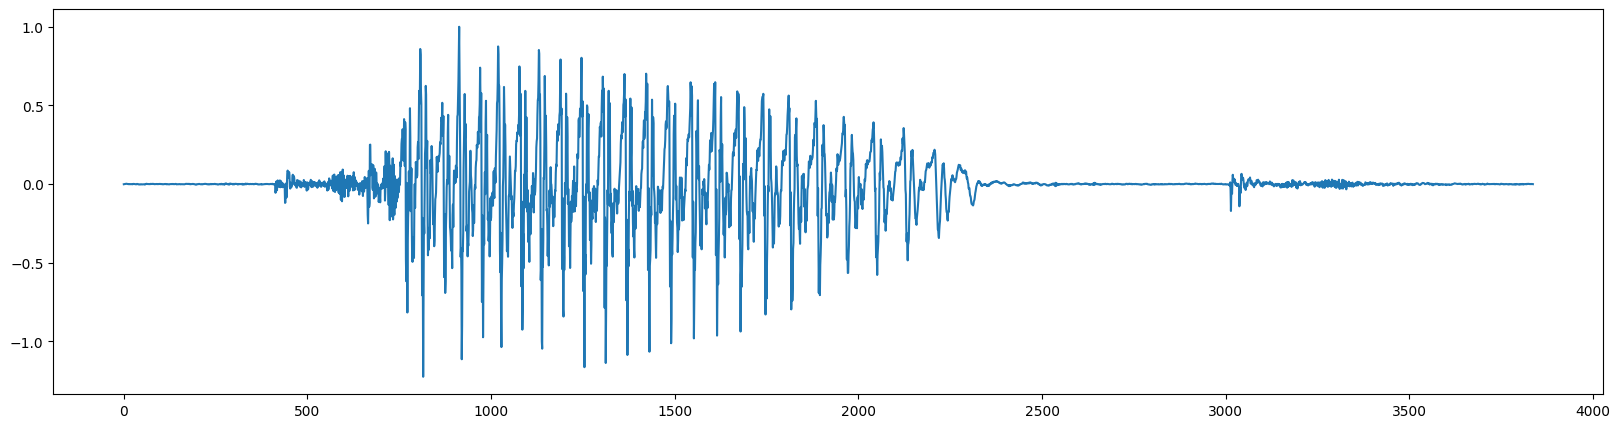

In [69]:
plt.figure(figsize=(20, 5))
plt.plot(audio)

Text(0.5, 0, 'Frequency (Hz)')

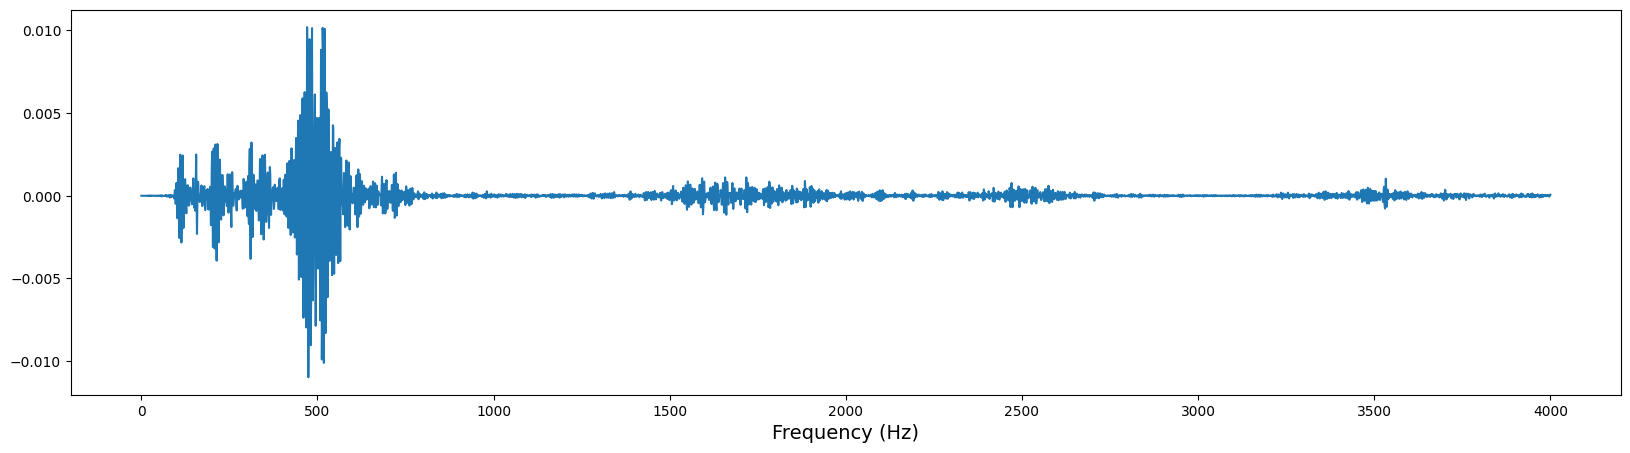

In [91]:
fourier_coefficients = np.fft.rfft(audio, norm="forward")
frequency_spectrum =  np.fft.rfftfreq(len(audio), 1 / sample_rate)
plt.figure(figsize=(20, 5))
plt.plot(frequency_spectrum, fourier_coefficients.real)
plt.xlabel("Frequency (Hz)", fontsize=14)

In [72]:
def bandpass_filter(frequencies, spectrum, min_freq, max_freq):
    """A bandpass filter.

    Keep only the parts of the frequency spectrum in a given range.

    Args:
        frequencies (array[float]): The frequencies of the Fourier coefficients
            (in Hz, obtained from np.fft.rfftfreqs).
        spectrum (array[complex]): The Fourier coefficients obtained by applying
            the FFT to an audio signal.
        min_freq (float): The minimum frequency, in Hz, allowed by the bandpass filter.
        max_freq (float): The maximum frequency, in Hz, allowed by the bandpass filter.

    Returns:
        array[complex]: A modified spectrum containing only the Fourier coefficients
        within the given frequency band.
    """
    freqs_out = spectrum.copy()
    for i in range(len(freqs_out)):
        if frequencies[i] < min_freq or frequencies[i] > max_freq:
            freqs_out[i] = 0

    return freqs_out

Text(0.5, 0, 'Frequency (Hz)')

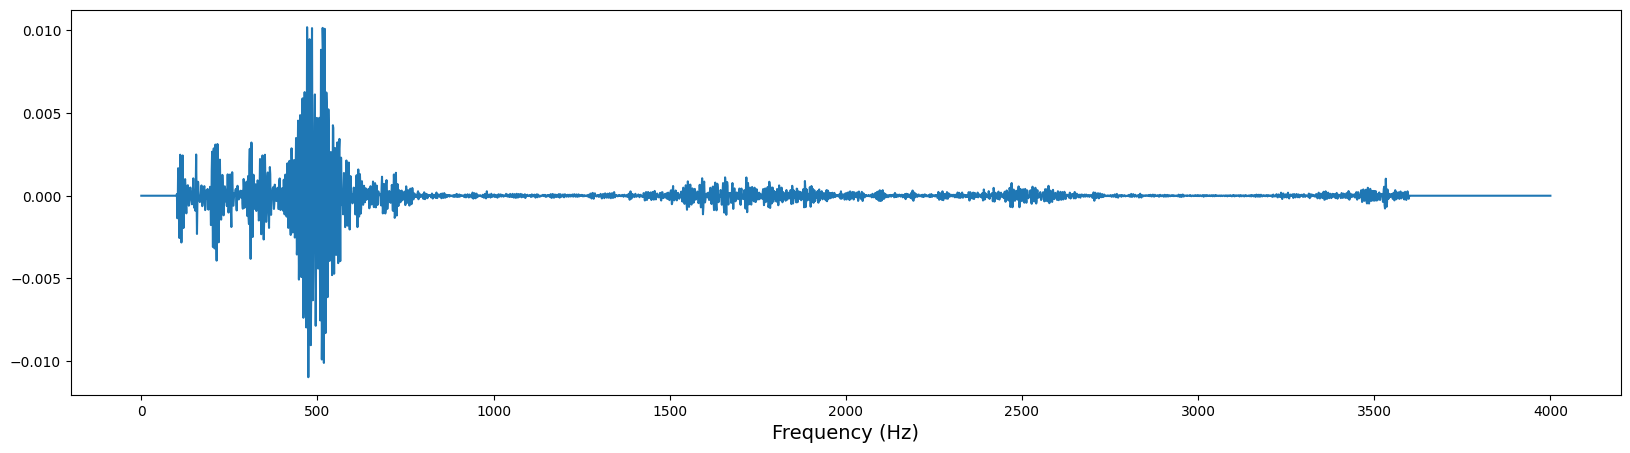

In [83]:
bandpassed_audio = bandpass_filter(frequency_spectrum, fourier_coefficients.real, 100, 3600)
plt.figure(figsize=(20, 5))
plt.plot(frequency_spectrum, bandpassed_audio)
plt.xlabel("Frequency (Hz)", fontsize=14)

In [84]:
audio_channel = np.fft.irfft(bandpassed_audio)
Audio(np.array(audio_channel, dtype=np.int16) / np.max(audio_channel), rate=sample_rate)

/usr/local/lib/python3.10/dist-packages/IPython/lib/display.py:174: RuntimeWarning: invalid value encountered in divide
  scaled = data / normalization_factor * 32767


In [94]:
channel_1 = np.fft.irfft(fourier_coefficients.real)
audio_channel = np.array(channel_1, dtype=np.float64) / np.max(channel_1)
Audio(np.array(audio_channel, dtype=np.int16) / np.max(audio_channel), rate=sample_rate)

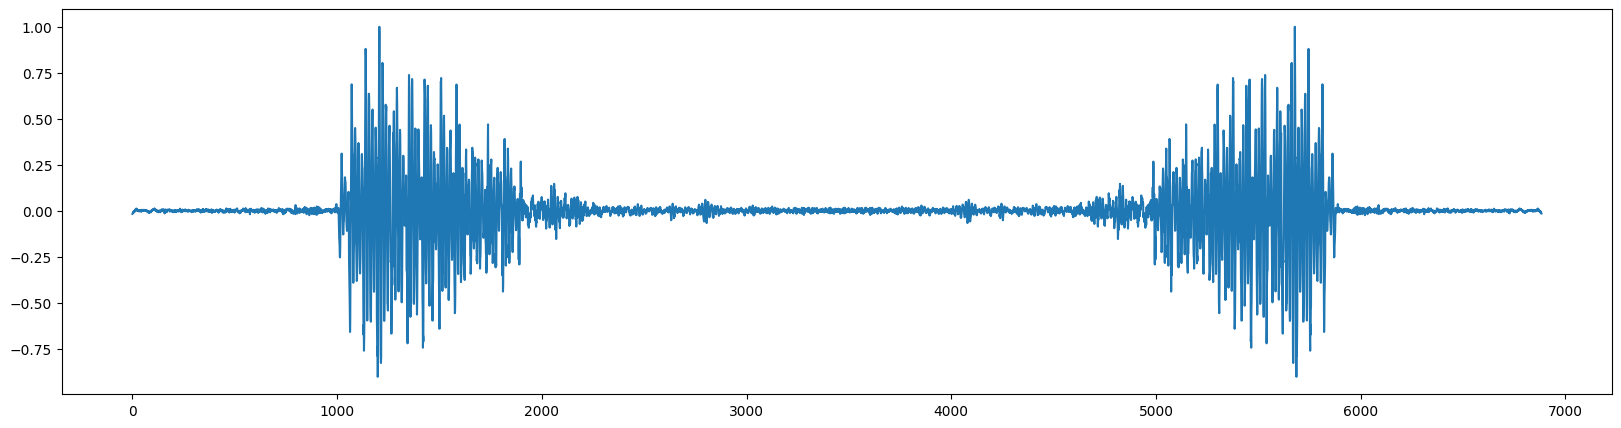

In [93]:
plt.figure(figsize=(20, 5))
plt.plot(audio_channel)